# Diagnosing Bias in Facial Detection Systems
To train our facial detection models, we will use two sets of data: The [positive examples](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) (i.e, of faces) and [negative examples](http://www.image-net.org/) (i.e, things that are not faces). These will be used to classficu the images as either faces or not faces. We will then evaluate the trained models on an independent test dataset of face images to diagnose potential issues with bias, fairess and confidence

### Dependencies

In [76]:
import tensorflow as tf #The main deep learning library
import numpy as np #For working with arrays
import os #For interacting with my operating system
import cv2 #For processing images
import pathlib
import matplotlib.pyplot as plt #For visualizing the images
import functools
import tqdm
    
import sys
import glob
from datasetloader import TrainingDatasetLoader
from utils import LossHistory, PeriodicPlotter


### Data Collection

Instantiate a TrainingDatasetLoader using the downloaded dataset

In [49]:
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
batch_size = 200
loader = TrainingDatasetLoader(path_to_training_data)

Opening /home/arnold/.keras/datasets/train_face.h5
Loading data...


Displaying some of the images to get a sense of what the training data actually looks like

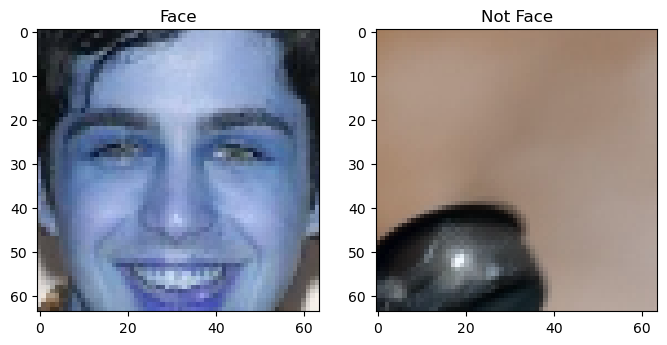

In [50]:
(images, labels) = loader.get_batch(100)
face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 19 #@param {type:"slider", min:0, max:50, step:1}
idx_not_face = 8 #@param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face"); plt.grid(False)
     

## CNN for facial Detection
Here, we will define and train a CNN model to classify whether a given image is a face or not. We will then evaluate its accuracy

### Define the CNN 
The CNN model has a standard acchitecture consisting of a series of convolution layers with batch normalization followed by fully connected layers (two in our case) to flatten the output and generate a loss prediction

In [51]:
n_filters = 12 # The base number for convolutional filters

def make_standard_classifier(n_outputs=1): # One output in the final layer
    # Creating partial functions to help in defining the CNN layers
    Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
    BatchNormalization = tf.keras.layers.BatchNormalization
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
    
    # Creating an instance of the sequential model
    model = tf.keras.Sequential([
        Conv2D(filters=1*n_filters, kernel_size=5, strides=2),
        BatchNormalization(),
        
        Conv2D(filters=2*n_filters, kernel_size=5, strides=2),
        BatchNormalization(),
        
        Conv2D(filters=4*n_filters, kernel_size=3, strides=2),
        BatchNormalization(),
        
        Conv2D(filters=6*n_filters, kernel_size=3, strides=2),
        BatchNormalization(),
        
        Flatten(),
        Dense(512),
        Dense(n_outputs, activation=None)
    ])
    return model
    
standard_classifier = make_standard_classifier()



### Train the CNN
We will train it using the tf.GradientTape class and the tf.GradientTape.gradient method

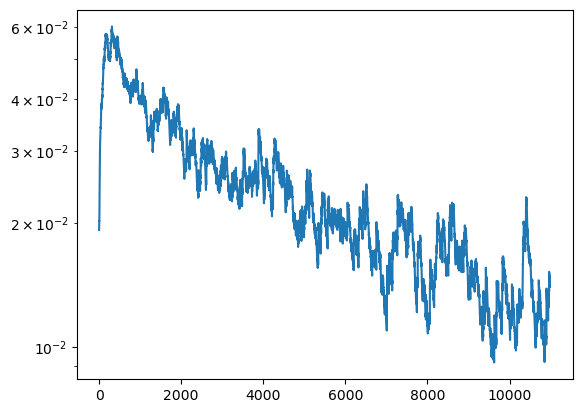

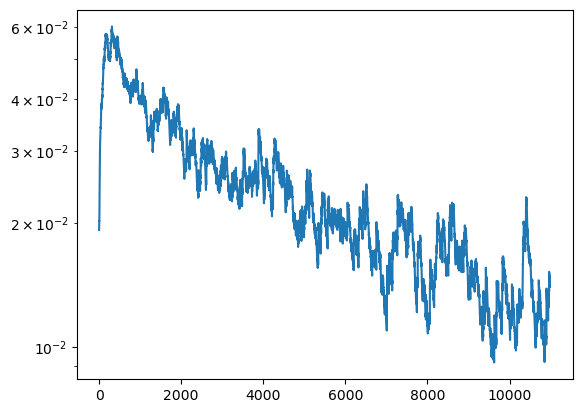

In [77]:
# Setting the training hyperparams
batch_size = 32 # Samples to be processed per iteration
num_epochs = 4 #  Number of times the entire dataset will be passed through the model during training
learning_rate = 0.00004 # The step size at each iteration during optimization process
train_size = len(loader.pos_train_inds) + len(loader.neg_train_inds)

optimizer = tf.keras.optimizers.Adam(learning_rate) # The optimizer usd to train the model
loss_history = LossHistory(smoothing_factor=0.99) # To record the loss values
plotter = PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): 
    tqdm._instances.clear() # Clears an instance of the progress bar if they exist

@tf.function
def standard_train_step(x, y): # Training step
    with tf.GradientTape() as tape:
        # Feed the images into the model
        logits = standard_classifier(x)
        # Compute the loss
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits) # Applies a sigmoid activation function and compues the cross-entropy loss between the true labels and the precicted logits
     # Back propagation
    grads = tape.gradient(loss, standard_classifier.trainable_variables) # Calculates the gradient loss wrt the trainable variables of the standard classifier model
    optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables)) # Use the computed gradients with the optimizer defined above to update the trainable variables
    return loss

# The training loss
for epoch in range(num_epochs):
    for idx in range(train_size//batch_size): # This ensures that the entire training dataset is processed in batches.
        x, y = loader.get_batch(batch_size) # Retrieving a batch of training data. x and y store image and corresponding labels respectively
        loss = standard_train_step(x, y) # Call the training function defined above to perform the training
        loss_history.append(loss.numpy().mean()) # add the loss values to the loss objects
        plotter.plot(loss_history.get()) # Plotting the evolution of the loss 
    
